In [1]:
import matplotlib.pyplot as plt
import numpy as np
import unittest
%matplotlib inline

In [2]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [4]:
def get_gray_img(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

In [5]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [6]:
def crop_img(img, keep_below=350):
    return img[keep_below:,:]

In [7]:
import glob
def get_vehicles():
    return glob.glob('./vehicles/**/*.png')

def get_non_vehicles():
    return glob.glob('./non-vehicles/**/*.png')


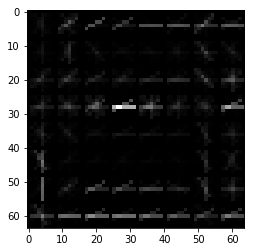

In [70]:
import cv2
gray = get_gray_img('./vehicles/GTI_MiddleClose/image0000.png')
features, hog_image = get_hog_features(gray, 8, 8, 2, vis=True)
plt.imshow(hog_image, cmap='gray')

In [9]:
def extract_features(imgs, cspace='RGB', orient=11, pix_per_cell=16, cell_per_block=2, spatial_feat=True, hist_feat=True, hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
            
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=(16, 16))
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=32)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

# of vehicles: 8792
# of non-vehicles: 8968


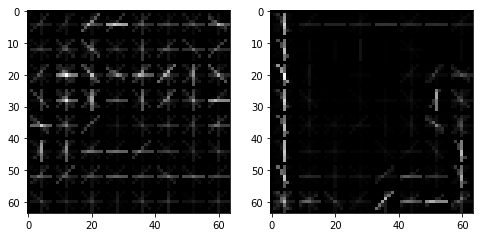

In [42]:
vehicles = get_vehicles()
non_vehicles = get_non_vehicles()

vehicle = cv2.cvtColor(cv2.imread(vehicles[0]), cv2.COLOR_RGB2YCrCb)
vehicle_features, vehicle_hog_image = get_hog_features(vehicle[:,:,2], 8, 8, 2, vis=True)

non_vehicle = cv2.cvtColor(cv2.imread(non_vehicles[0]), cv2.COLOR_RGB2YCrCb)
non_vehicle_features, non_vehicle_hog_image = get_hog_features(non_vehicle[:,:,2], 8, 8, 2, vis=True)

print('# of vehicles: %d' % len(vehicles))
print('# of non-vehicles: %d' % len(non_vehicles))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax = ax.ravel()
ax[0].imshow(vehicle_hog_image, cmap='gray')
ax[1].imshow(non_vehicle_hog_image, cmap='gray')

#### Make sure extract_features is working as expected.

In [11]:
vehicles = [get_vehicles()[0]]
extracted_features = extract_features(vehicles)
img = cv2.cvtColor(cv2.imread(vehicles[0]), cv2.COLOR_BGR2RGB)
hog_features = [get_hog_features(img[:,:,0], 9, 8, 2)]
#np.testing.assert_array_equal(extracted_features, hog_features)

/Users/kevinwestern/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


#### Now let's load the cars and non cars data

In [37]:
COLOR_SPACE = 'YCrCb'
ORIENT = 8
PIX_PER_CELL = 8
CELL_PER_BLOCK = 2
HOG_CHANNEL = 'ALL'
BIN_SIZE = (16, 16)
HIST_BINS = 32
HIST_RANGE = (0, 256)

In [38]:
car_features = extract_features(
    get_vehicles(),
    cspace=COLOR_SPACE,
    orient=ORIENT,
    pix_per_cell=PIX_PER_CELL,
    hog_channel=HOG_CHANNEL)
non_car_features = extract_features(
    get_non_vehicles(),
    cspace=COLOR_SPACE,
    orient=ORIENT,
    pix_per_cell=PIX_PER_CELL,
    hog_channel=HOG_CHANNEL)

#### And create our features and labels

In [39]:
from sklearn.preprocessing import StandardScaler

# Create rows of features
# np.vstack([1,2], [3,4]) ->
# [[1,2],
#  [3,4]]
X = np.vstack((car_features, non_car_features)).astype(np.float64)
# Don't scale since we're not combining features
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Create labels
# np.hstack([1,2],[3,4]) ->
# [1,2,3,4]
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

#### And split it up

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, shuffle=True)

#### Now build a model since we have training and test data.

In [41]:
from sklearn.svm import LinearSVC

svc = LinearSVC()
svc.fit(X_train, y_train)
accuracy = svc.score(X_test, y_test)
print('Accuracy of %f' % accuracy)

Accuracy of 0.992399


In [16]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5), debug=False):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    if debug:
        print('xspan: %f' % xspan)
        print('yspan: %f' % yspan)
        print('nx_pix_per_step: %f' % nx_pix_per_step)
        print('ny_pix_per_step: %f' % ny_pix_per_step)
        print('nx_buffer: %f' % nx_buffer)
        print('ny_buffer: %f' % ny_buffer)
        print('nx_windows: %f' % nx_windows)
        print('ny_windows: %f' % ny_windows)
    return window_list


In [17]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6, yolo=False):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if yolo:
            color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [18]:
img = cv2.imread('./test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img[400:656,:,:]
windows = slide_window(img)

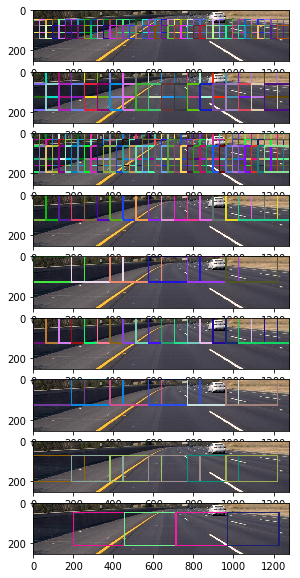

In [19]:
all_windows = [
    slide_window(
        img,
        x_start_stop=(0, img.shape[1]),
        y_start_stop=(50, 150)),
    slide_window(
        img,
        x_start_stop=(0, img.shape[1]),
        y_start_stop=(0, 200),
        xy_window=(128, 128)),
    slide_window(
        img,
        x_start_stop=(0, img.shape[1]),
        y_start_stop=(0, 200),
        xy_window=(128, 128),
        xy_overlap=(0.75, 0.75),
        debug=False),
    slide_window(
        img,
        x_start_stop=(0, img.shape[1]),
        y_start_stop=(0, 150),
        xy_window=(256, 128),
        xy_overlap=(0.75, 0.75)),
    slide_window(
        img,
        x_start_stop=(0, img.shape[1]),
        y_start_stop=(0, 150),
        xy_window=(256, 128),
        xy_overlap=(0.25, 0.25)),
    slide_window(
        img,
        x_start_stop=(0, img.shape[1]),
        y_start_stop=(0, 150),
        xy_window=(256, 128),
        xy_overlap=(0.75, 0.75)),
    slide_window(
        img,
        x_start_stop=(0, img.shape[1]),
        y_start_stop=(0, 150),
        xy_window=(256, 128),
        xy_overlap=(0.25, 0.25)),
    slide_window(
        img,
        x_start_stop=(0, img.shape[1]),
        y_start_stop=(75, img.shape[0]),
        xy_window=(256, 128),
        xy_overlap=(0.25, 0.25)),
    slide_window(
        img,
        x_start_stop=(200, 1400),
        y_start_stop=(50, img.shape[0]),
        xy_window=(256, 164),
        xy_overlap=(0.0, 0.0))
]

fig, ax = plt.subplots(nrows=len(all_windows), ncols=1, figsize=(10, 10))
ax = ax.ravel()
for i in range(len(all_windows)):
    ax[i].imshow(draw_boxes(img, all_windows[i], yolo=True))


## Extract features from a single image. This will be used in addition to the sliding window.

In [20]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='YCrCb', spatial_size=(16, 16),
                        hist_bins=32, orient=11, 
                        pix_per_cell=16, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

#### Look through a list of windows and return the ones we think have cars.

In [21]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='YCrCb', 
                    spatial_size=(16, 16), hist_bins=32, 
                    hist_range=(0, 256), orient=11, 
                    pix_per_cell=16, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

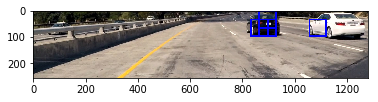

In [45]:
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img[400:656,:,:]
windows = slide_window(img)
matches = search_windows(
    img,
    windows,
    svc,
    X_scaler,
    color_space=COLOR_SPACE,
    orient=ORIENT,
    pix_per_cell=PIX_PER_CELL,
    cell_per_block=CELL_PER_BLOCK,
    hog_channel=HOG_CHANNEL,
    spatial_feat=True,
    hist_feat=True)
plt.imshow(draw_boxes(img, matches))

#### Instead of searching window, let's try subsampling in one pass.

In [73]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
              debug=False):
    
    #img = img.astype(np.float32)/255
    matches = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block  + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=(16, 16))
            hist_features = color_hist(subimg, nbins=32)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            #test_prediction = svc.predict(np.array(hog_features).reshape(1, -1))
            
            if test_prediction == 1 or debug:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                matches.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return matches

49


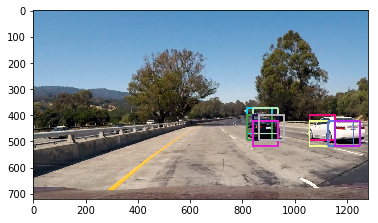

In [72]:
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

matches = find_cars(img, 350, 656, 1.5, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False)
plt.imshow(draw_boxes(img, matches, yolo=True))

#### Let's experiment with different params for find_cars.

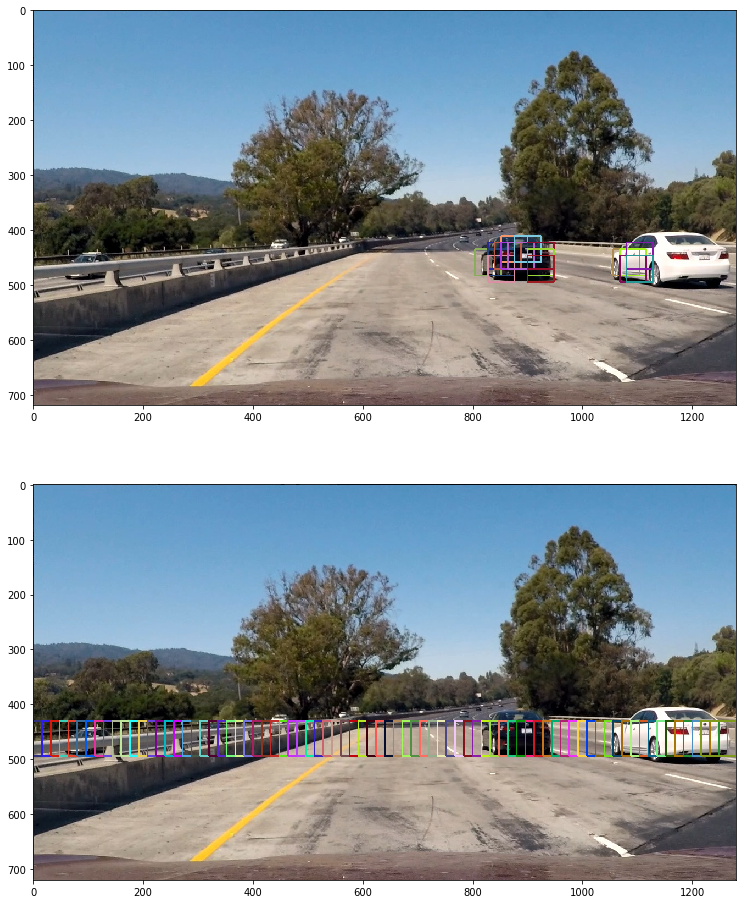

In [47]:
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tests = [
    find_cars(img, 400, 500, .75, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
    find_cars(img, 430, 505, 1, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=True),
]

fig, ax = plt.subplots(nrows=len(tests), ncols=1, figsize=(16, 16))
ax = ax.ravel()
for i in range(len(tests)):
    ax[i].imshow(draw_boxes(img, tests[i], thick=2,  yolo=True))

    

/Users/kevinwestern/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


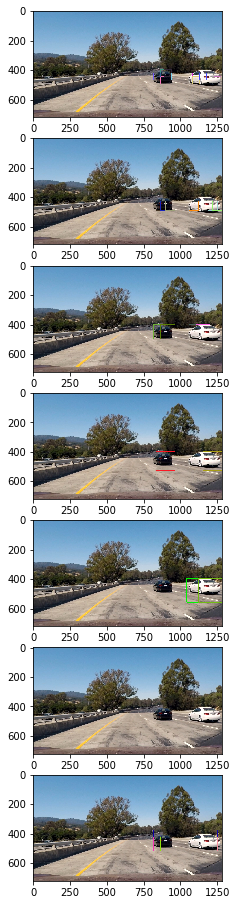

In [26]:
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tests = [
    find_cars(img, 400, 500, .75, svc, X_scaler, 11, 16, 2, None, None, debug=False),
    find_cars(img, 430, 505, 1, svc, X_scaler, 11, 16, 2, None, None, debug=False),
    find_cars(img, 400, 656, 1.5, svc, X_scaler, 11, 16, 2, None, None, debug=False),
    find_cars(img, 400, 550, 2, svc, X_scaler, 11, 16, 2, None, None, debug=False),
    find_cars(img, 400, 600, 2.5, svc, X_scaler, 11, 16, 2, None, None, debug=False),
    find_cars(img, 425, 575, 2, svc, X_scaler, 11, 16, 2, None, None, debug=False),
    find_cars(img, 375, 600, 1.5, svc, X_scaler, 11, 16, 2, None, None, debug=False),
]

fig, ax = plt.subplots(nrows=len(tests), ncols=1, figsize=(16, 16))
ax = ax.ravel()
for i in range(len(tests)):
    ax[i].imshow(draw_boxes(img, tests[i], thick=2,  yolo=True))

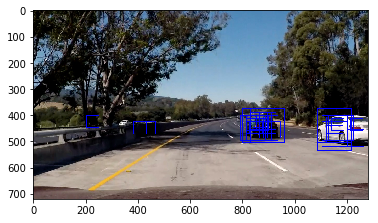

In [83]:
img = cv2.imread('./test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tests = [
    find_cars(img, 400, 500, .75, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
    find_cars(img, 430, 505, 1, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
    find_cars(img, 400, 656, 1.5, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
    find_cars(img, 400, 550, 2, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
    find_cars(img, 400, 600, 2.5, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
    find_cars(img, 425, 575, 2, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
    find_cars(img, 375, 600, 1, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
    find_cars(img, 375, 600, 2, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
]

matches = []
for rects in tests:
    for bboxes in rects:
        matches.append(bboxes)
plt.imshow(draw_boxes(img, matches, thick=2,  yolo=False))

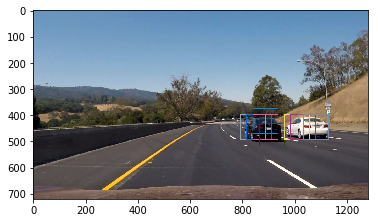

In [63]:
img = cv2.imread('./debug/img0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tests = [
    find_cars(img, 350, 656, 1.5, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
]

plt.imshow(draw_boxes(img, tests[0], thick=2,  yolo=True))

#fig, ax = plt.subplots(nrows=len(tests), ncols=1, figsize=(16, 16))
#ax = ax.ravel()
#for i in range(len(tests)):
#    ax[i].imshow(draw_boxes(img, tests[i], thick=2,  yolo=True))

In [29]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [30]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

#### Let's combine all the results from find_cars

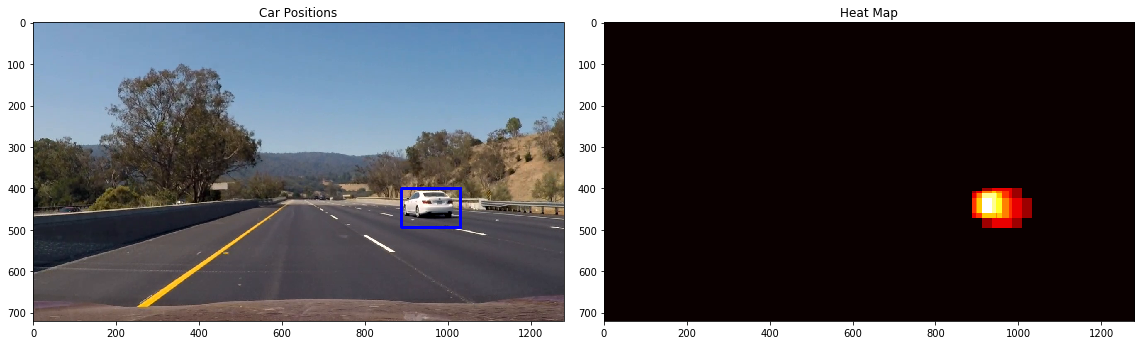

In [84]:
from scipy.ndimage.measurements import label
img = cv2.imread('./debug/img0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tests = [
    find_cars(img, 400, 500, .75, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
    find_cars(img, 430, 505, 1, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
    find_cars(img, 400, 656, 1.5, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
    find_cars(img, 400, 550, 2, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
    find_cars(img, 400, 600, 2.5, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
    find_cars(img, 425, 575, 2, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
    find_cars(img, 375, 600, 1, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
    find_cars(img, 375, 600, 2, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
]
matches = []
for boxes in tests:
    for box in boxes:
        matches.append(box)

heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, matches)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize=(16, 9))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [85]:
from moviepy.editor import VideoFileClip
from functools import reduce

history = []
counter = -1
last_result = None
img_counter = 0
debug = False
def process_image(img):
    global history
    global counter
    global img_counter
    global debug
    global last_result
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if debug:
        cv2.imwrite('./debug/img%d.png' % img_counter, img_rgb)
        img_counter = img_counter + 1
    counter = counter + 1
    
    # Only process every third frmae.
    if counter % 3 is 0:
        counter = 0

        tests = [
            find_cars(img, 400, 500, .75, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
            find_cars(img, 430, 505, 1, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
            find_cars(img, 400, 656, 1.5, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
            find_cars(img, 400, 550, 2, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
            find_cars(img, 400, 600, 2.5, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
            find_cars(img, 425, 575, 2, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
            find_cars(img, 375, 600, 1, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
            find_cars(img, 375, 600, 2, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None, None, debug=False),
        ]
        matches = []
        for boxes in tests:
            for box in boxes:
                matches.append(box)
        heat = np.zeros_like(img[:,:,0]).astype(np.float)

        # Add heat to each box in box list
        heat = add_heat(heat, matches)
        history.append(heat)
        if len(history) >= 5:
            history = history[-5:]

        # Thank's to darienmt for the reduce technique.
        avg = reduce(lambda h, acc: h + acc, history) / 5

        # Apply threshold to help remove false positives
        heat = apply_threshold(avg, 2)

        # Visualize the heatmap when displaying    
        #heatmap = np.clip(heat, 0, 255)

        labels = label(heat)
        last_result = labels
    else:
        labels = last_result

    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')
video = video_input.fl_image(process_image)
video.write_videofile(video_output)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing audio in project_video_outputTEMP_MPY_wvf_snd.mp3


100%|██████████| 1112/1112 [00:01<00:00, 987.71it/s] 

[MoviePy] Done.
[MoviePy] Writing video project_video_output.mp4



100%|█████████▉| 1260/1261 [13:58<00:00,  1.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [673]:
print(np.average(history, axis=2))

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
1.0
1.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
1.0
1.0
1.0
1.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
1.0
1.0
